In [2]:
import os
import sys
import json
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#sys.path.insert(0, '/mnt/d/projects/bassline_transcription')
sys.path.insert(0, '/scratch/users/udemir15/ELEC491/bassline_transcription')

from utilities import *
from bassline_transcriber.transcription.representation import transpose_to_C, fill_midi_array, convert_to_vector

In [26]:
def merge_track_dicts(*args):
    track_dicts = {}
    for dct in args:
        track_dicts = {**track_dicts, **dct}
    return track_dicts

def create_dataframes(track_dicts, M, directories):
    
    track_titles = track_dicts.keys()
    
    error_counter = 0 # to count the losses
    filtered_counter = 0 
    
    codebook_pre, codebook_after = set(), set()
    minor_matrix, major_matrix = [], []
    minor_titles, major_titles = [], []
    for title in track_titles:

        try:
            vector = load_symbolic_representation(title, directories, M) # already transposed
            
            if filter_vector(vector):
            
                codebook_pre = codebook_pre.union(set(vector))

                vector = fix_codes(vector) # make the codes consecutive
                codebook_after = codebook_after.union(set(vector))

                scale_type = track_dicts[title]['Key'].split(' ')[-1]           

                if scale_type == 'min':
                    minor_matrix.append(vector)
                    minor_titles.append(title)

                elif scale_type == 'maj':
                    major_matrix.append(vector)
                    major_titles.append(title)
            else:
                filtered_counter += 1
                
        except FileNotFoundError:
            error_counter += 1
        except Error:
            print('Unexpected error.')
            
    print('\nCodebook before correction:\n{}'.format(codebook_pre))
    print('\nCodebook after correction:\n{}'.format(codebook_after))
            
    print('\n{}/{} Tracks couldnt found!'.format(error_counter, len(track_titles)))
    print('\n{}/{} Tracks filtered out!'.format(filtered_counter, len(track_titles)))

    major_matrix = np.stack(major_matrix, axis=0)
    minor_matrix = np.stack(minor_matrix, axis=0)

    df_minor = pd.DataFrame(minor_matrix)
    df_major = pd.DataFrame(major_matrix)

    df_minor['Title'] = minor_titles
    df_major['Title'] = major_titles

    df_minor = df_minor.reindex(columns=['Title'] + [x for x in np.arange(len(vector))])
    df_major = df_major.reindex(columns=['Title'] + [x for x in np.arange(len(vector))])
    
    for i in np.diff(list(codebook_after)):
        if i > 1:
            print('\nNonconsecutive codes!!!!')
        
    return df_minor, df_major

def filter_vector(vector, sustain=100, silence=0):
    
    flag = True
    for code in vector:
        if code != sustain and code != silence:
            if (code > MAX_NOTE_CODE) or (code < MIN_NOTE_CODE):
                flag=False
                break
            
    return flag
    

def fix_codes(X, sustain=100, silence=0):
    """Make consecutive"""  
    
    X[X==sustain] = MAX_NOTE_CODE+1
    X[X!=silence] -= MIN_NOTE_CODE-1
    
    return X

def count_keys(df, merged_track_dicts):
    
    counter = Counter()
    for title in df['Title']:

        track = merged_track_dicts[title]
        key, scale_type = track['Key'].split(' ')        
        counter[key] += 1

    return dict(sorted(counter.items(), key=lambda x: x[0].lower()))   

def key_pie_charts(m_counter, M_counter):

    fig, ax = plt.subplots(ncols=2, figsize=(16,7), constrained_layout=True)
    
    values = np.array(list(m_counter.values()))
    explode = np.zeros(12)
    explode[np.argpartition(values, -3)[-3:]] = [0.05, 0.1, 0.2]

    ax[0].set_title('Minor Keys Bassline Transcriptions', fontsize=15)
    ax[0].pie(values, explode=explode, labels=m_counter.keys(),textprops={'fontsize': 15})
    ax[0].axis('equal')

    values = np.array(list(M_counter.values()))
    explode = np.zeros(12)
    explode[np.argpartition(values, -3)[-3:]] = [0.05, 0.1, 0.2]

    ax[1].set_title('Major Keys Bassline Transcriptions', fontsize=15)
    ax[1].pie(values, explode=explode, labels=M_counter.keys(),textprops={'fontsize': 15})
    ax[1].axis('equal')
    plt.show()
    
def count_notes(track_dicts, directories, M):
    
    note_counter, note_counter_T = Counter(), Counter()
    for title, track in track_dicts.items():

        try:    
            midi_array = load_bassline_midi_array(title, directories, M)
            midi_notes = midi_array[:,1].astype(int)
            
            key, scale_type = track['Key'].split(' ')
            
            midi_array_T = transpose_to_C(midi_array, key)
                        
            midi_notes_T = midi_array_T[:,1].astype(int)
            
            for note in midi_notes:
                note_counter[note] += 1

            for note in midi_notes_T: 
                note_counter_T[note] += 1
        except:
            pass
            #print('Unexpected Error!')

    note_counter = dict(sorted(note_counter.items(), key=lambda x: x[0]))
    note_counter_T = dict(sorted(note_counter_T.items(), key=lambda x: x[0]))    
    
    return note_counter, note_counter_T

def plot_note_occurances(note_counter, note_counter_T, M):

    vals, labels = zip(*note_counter.items())
    vals_T, labels_T = zip(*note_counter_T.items())
    
    min_orig, max_orig = min(vals), max(vals)
    min_T, max_T = min(vals_T), max(vals_T)
    print('Original min: {}, max: {}'.format(min_orig, max_orig))
    print('Transposed min: {}, max: {}'.format(min_T, max_T))

    #pitches = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    #p = ['B#0'] + [pitch+'1' for pitch in pitches] + [pitch+'2' for pitch in pitches] + ['C3']

    fig, ax = plt.subplots(nrows=2, figsize=(20,10), sharex=True)
    fig.suptitle('MIDI Number Occurance Frequencies (M={})'.format(M), fontsize=22)

    ax[0].set_title('Without Transposing', fontsize=18)
    ax[0].set_xlim([min_orig-1, max_orig+1])
    ax[0].bar(vals, labels)
    ax[0].tick_params(axis='both', which='major', labelsize=15)

    ax[1].set_title('After Transposing', fontsize=18)
    ax[1].set_xlim([min_T-1, max_T+1])
    ax[1].bar(vals_T, labels_T)
    ax[1].vlines([30, 48], 0, 25000, color='r', linewidth=5)
    ax[1].vlines([28, 51], 0, 25000, color='g', linewidth=5)
    ax[1].tick_params(axis='both', which='major', labelsize=15)

    #plt.savefig('MIDI_number_distribution.jpg')
    plt.show()

In [20]:
directories = get_directories('../data/directories.json')

track_dicts_name = 'traxsource_crawl_0_2500_track_dicts.json'
_, track_dicts0, track_titles0 = read_metadata(directories, track_dicts_name)

track_dicts_name = 'traxsource_crawl_2500_5000_track_dicts.json'
_, track_dicts1, track_titles1 = read_metadata(directories, track_dicts_name)

track_dicts = merge_track_dicts(track_dicts0, track_dicts1)
track_titles = list(track_dicts.keys())

## Analyzing

In [27]:
ORIGINAL_MAX = 60 # Middle C = C4
ORIGINAL_MIN = 25 # C#

MAX_NOTE_CODE = 51 # Middle C = C4
MIN_NOTE_CODE = 28 # C#

(3481, 65)


Codebook before correction:
{0, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 100}

Codebook after correction:
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25}

287/4555 Tracks couldnt found!

442/4555 Tracks filtered out!


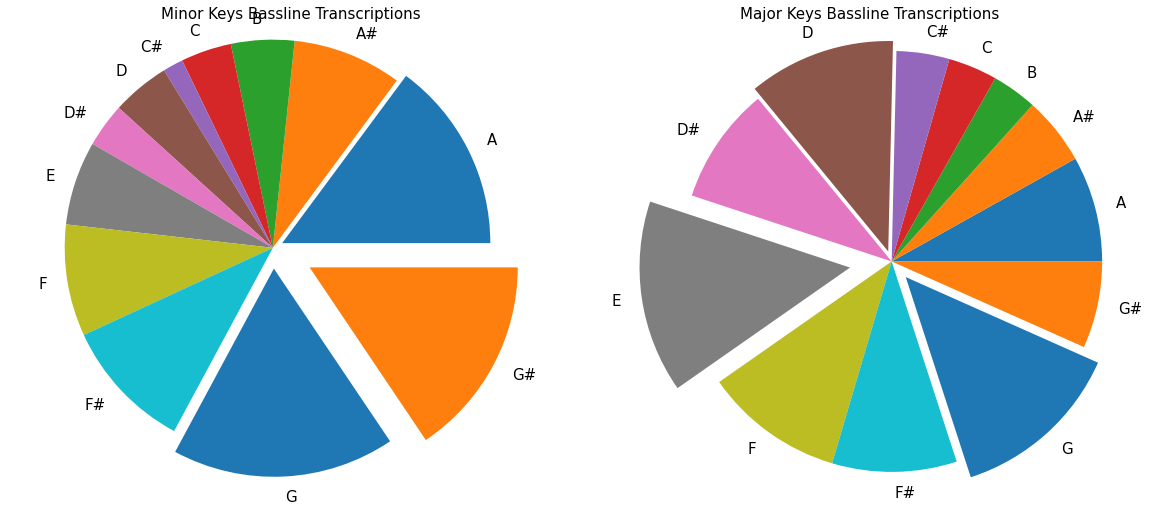

(3481, 65) (345, 65)


In [33]:
M=8
representation_path = os.path.join('..','data','datasets')
df_minor, df_major = create_dataframes(track_dicts, M, directories)

m_counter = count_keys(df_minor, track_dicts)
M_counter = count_keys(df_major, track_dicts)

key_pie_charts(m_counter, M_counter)

print(df_minor.shape, df_major.shape)

Original min: 35, max: 60
Transposed min: 25, max: 60


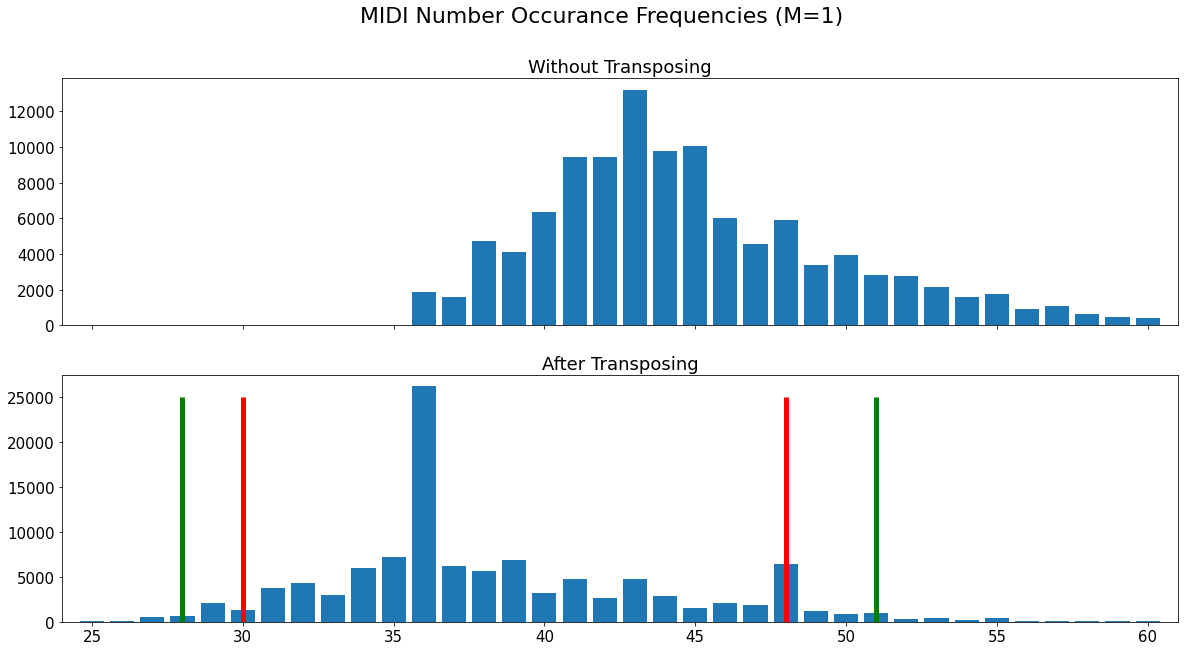

In [31]:
M=1
note_counter, note_counter_T = count_notes(track_dicts, directories, M)

plot_note_occurances(note_counter, note_counter_T, M)

In [36]:
representation_path = os.path.join('..','data','datasets','[28, 51]')

for M in [1, 2, 4, 8]:
    df_minor, df_major = create_dataframes(track_dicts, M, directories)

    min_title = 'traxsource_0-5000_bassline_representations_min_M{}.csv'.format(M)
    min_dir = os.path.join(representation_path, min_title)
    df_minor.to_csv(min_dir, index=False, header=False)

    maj_title = 'traxsource_0-5000_bassline_representations_maj_M{}.csv'.format(M)
    maj_dir = os.path.join(representation_path, maj_title)
    df_major.to_csv(maj_dir, index=False, header=False)


Codebook before correction:
{0, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 100}

Codebook after correction:
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25}

272/4555 Tracks couldnt found!

502/4555 Tracks filtered out!

Codebook before correction:
{0, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 100}

Codebook after correction:
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25}

272/4555 Tracks couldnt found!

502/4555 Tracks filtered out!

Codebook before correction:
{0, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 100}

Codebook after correction:
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25}

270/4555 Tracks couldnt found!

503/4555 Tracks filtered out!

Codebook before correction:
{0, 28, 29,

## Creating The Representation

In [ ]:
def load_numpy_midi(file_name, directory):  
    
    return np.load(os.path.join(directory, file_name))

def create_scale_pitches(key, typ):
    
    scale_pitches = scales[key][typ]['notes']

    midi_notes = [24 + pitches.index(pitch) for pitch in scale_pitches]
    midi_notes.extend([36 + pitches.index(pitch) for pitch in scale_pitches])
    
    return midi_notes

#M = 8

#midi_dir = os.path.join(directories['transcription']['midi_notes'], 'M={}'.format(M))
midi_dir = directories['transcription']['midi_notes']

file_names = next(os.walk(midi_dir))[-1]

In [ ]:
pitches = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

In [ ]:
N_bars = 4
frame_factor = 8
M=8

for file_name in file_names:
    
    midi_array = load_numpy_midi(file_name, midi_dir)
    
    title = file_name.split('.npy')[0]
    key, typ = track_dicts[title]['Key'].split(' ')
       
    N_intervals = pitches.index(key)
    
    
    if midi_array.shape[0] > 2:

        midi_array_T = transpose_to_C(midi_array, N_intervals)

        symbolic_representation = get_symbolic_representation(midi_array, N_bars, frame_factor, M)

        #print(len(symbolic_representation))
        
        print(symbolic_representation)

In [ ]:
indices = []
rows = []
for idx, midi in enumerate(midi_array[:-1]):
    
    end = midi[0] + midi[3]
    if end != midi_array[idx+1, 0]:
        indices.append(idx+1)
        rows.append([end , 0, 120, midi_array[idx+1, 0]-end])

midi_array = np.insert(midi_array, indices, rows, axis=0)

if midi_array[0,0] != 0.0:
    midi_array=np.insert(midi_array, 0, [0.0, 0, midi_array[0,2], midi_array[0,0]], axis=0)

end = midi_array[-1,0] + midi_array[-1,3]
if end != N_bars*4:
    midi_array=np.insert(midi_array, -1, [end, 0, midi_array[-1,2], N_bars*4-end], axis=0)

In [ ]:
delta = 0.25 * (frame_factor / M) # N_pqb

vector = []
for midi in midi_array:
    
    note = midi[1]
    duration = (midi[3]/delta).astype(int)
    
    vector += [note]*duration

## Analysis

In [ ]:
minor_pitches, major_pitches = [], []
minor_pitches_T, major_pitches_T = [], []

for file_name in file_names:
    
    midi_array = load_numpy_midi(file_name, midi_dir)
    
    title = file_name.split('.npy')[0]
    key, typ = track_dicts[title]['Key'].split(' ')
       
    N_intervals = pitches.index(key)
    
    if midi_array.size > 1:
        
        notes = midi_array[:,1].astype(int)
        
        #transpose
        notes_T = [note-N_intervals for note in notes]
                
        midi_array[:,1] = notes_T        
        
        if typ == 'maj':
            major_pitches.extend(notes)
            major_pitches_T.extend(notes_T)
        else:
            minor_pitches.extend(notes)
            minor_pitches_T.extend(notes_T)
            
print('Lowest Major Key Midi Idx: {}\nAfter Transposition: {}'.format(min(major_pitches),min(major_pitches_T)))
print('\nLowest Minor Key Midi Idx: {}\nAfter Transposition: {}'.format(min(minor_pitches),min(minor_pitches_T)))

## Sketcehs

if key_id <= 5:
    notes_T = [note-key_id for note in notes]
else:
    notes_T = [note+(12-key_id) for note in notes]
    
    
        if min(notes_T) < 24:
            print('Key: {} {}, N_intervals: {}'.format(key,typ,N_intervals))
            print('Scale MIDI: {}'.format(create_scale_pitches(key, typ)))
            print('Pitches: {}\nTransposed: {}\n'.format(notes, notes_T))

idx = 3

2*(pitches[idx-12:] + pitches[:idx])